## Implementation of the LSTM model

---

This notebook contains the implementation of the LSTM network described in the report.
Data is from https://data.open-power-system-data.org/time\_series/

Mikkel Godtfredsen Feb-Jun, 2021

In [ ]:
# Import libraries and modules
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
# Import data and load into dataframe.
data = pd.read_csv("/content/drive/MyDrive/time_series_60min_singleindex_filtered.csv",parse_dates=[0])
data = pd.DataFrame(data)
# Drop single outlier and sum up columns
total_load = data[data.columns[:]].sum(axis=1)
data['total_load'] = total_load
data = data.drop(columns=data.columns[1:59])
data = data.drop([np.argmax(data['total_load'])])
data = data.drop([0]).reset_index(drop=True)
data = data.rename(columns={'utc_timestamp':'datetime'})

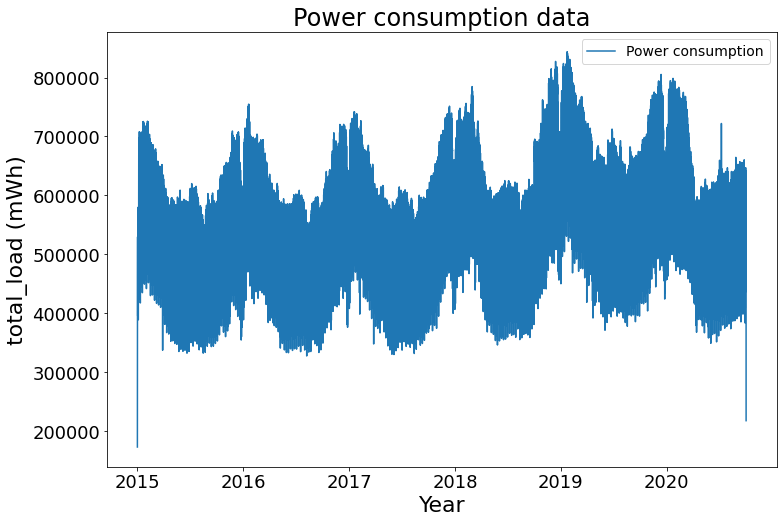

In [ ]:
# Visualize the dataset
ticks = [np.min(np.where(data['datetime'].dt.year == 2015+i)[0]) for i in range(6)]
fig = plt.figure(figsize=(12,8))
plt.plot(data['total_load'],label='Power consumption')
plt.title('Power consumption data',fontsize=24)
plt.xlabel('Year',fontsize=22)
plt.ylabel('total_load (mWh)',fontsize=22)
plt.xticks(ticks,[2015,2016,2017,2018,2019,2020],fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)
plt.savefig('powerdata.png',bbox_inches='tight')

In [ ]:
# Class to define time series dataset.
# Defines source and target sequence.
class TimeSeriesDataset(Dataset):
  def __init__(self,data,src_len,tgt_len):
    rang = len(data)-src_len-tgt_len
    self.x = torch.Tensor([data[i:(i+src_len)] for i in range(rang)])
    self.y = torch.Tensor([data[(i+src_len):(i+src_len+tgt_len)] for i in range(rang)])
    self.n_samples = self.x.shape[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

In [ ]:
# Class to define the network
class LSTM(torch.nn.Module):
  def __init__(self, src_len, tgt_len, hidden_size, input_size=1,n_layers=1):
    super(LSTM, self).__init__()   
    self.src_length = src_len 
    self.tgt_len = tgt_len
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.n_layers = n_layers
    self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=n_layers,batch_first=True)
    self.linear = torch.nn.Linear(hidden_size, tgt_len)
  def forward(self, x):
    hidden_cell = (Variable(torch.zeros(self.n_layers,x.size(0),self.hidden_size)).to(device),Variable(torch.zeros(self.n_layers,x.size(0),self.hidden_size)).to(device))
    out, (hidden_out, _) = self.lstm(x, hidden_cell)
    hidden_out = hidden_out.view(-1, self.hidden_size)
    output = self.linear(hidden_out)  
    return output

In [ ]:
# Subsample the dataset for experiments
data_rnn = data.set_index('datetime')
data_monthly = data_rnn.resample('M').sum()
data_weekly = data_rnn.resample('W').sum()
data_daily = data_rnn.resample('D').sum()

# Choose which data representation to use
data_used = data_daily

# Scale the data
scaler = MinMaxScaler(feature_range=(-1,1))
data_normalized = scaler.fit_transform(data_used)

# Split data into training, validation, and test sets
train_size,val_size = 0.6,0.2
train,val = data_normalized[:int(train_size*len(data_normalized))], data_normalized[int(train_size*len(data_normalized)):int((train_size+val_size)*len(data_normalized))]
test = data_normalized[int((train_size+val_size)*len(data_normalized)):]

# Create time series dataset and dataloaders
batch_size = len(train)%128 and len(val)%128
src_len = 50
tgt_len = 50
train, val, test = TimeSeriesDataset(train,src_len,tgt_len), TimeSeriesDataset(val,src_len,tgt_len), TimeSeriesDataset(test,src_len,tgt_len)
dataloader_train = DataLoader(dataset=train,batch_size=batch_size,shuffle=False,num_workers=0)
dataloader_val = DataLoader(dataset=val,batch_size=batch_size,shuffle=False,num_workers=0)
dataloader_test = DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=0)

In [ ]:
cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [ ]:
# Define the model and train
def def_model(parameters):
  learning_rate,hidden_size = parameters[0],int(parameters[1])
  return learning_rate, LSTM(src_len,tgt_len,hidden_size).to(device)

def train_loop(model,epochs,adaptive):
  learning_rate,model = model
  loss = torch.nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

  best_loss = 100
  patience = 40

  train_losses = []
  val_losses = []

  for i in range(epochs):
    tr_loss = 0
    model.train()
    for j, (x,y) in enumerate(dataloader_train):
      x, y = x.to(device),y.to(device)
      out = model(x)
      optimizer.zero_grad()
      train_loss = loss(out,y.reshape(y.shape[0],-1))
      train_loss.backward()
      optimizer.step()
      tr_loss += train_loss.item()
    tr_loss /= train.n_samples/batch_size
    train_losses.append(tr_loss)

    model.eval()
    validation_loss = 0
    with torch.no_grad():
      for k, (x_val, y_val) in enumerate(dataloader_val):
        x_val, y_val = x_val.to(device), y_val.to(device)
        out_val = model(x_val)
        validation_loss += loss(out_val,y_val.reshape(y_val.shape[0],-1))

      validation_loss /= val.n_samples/batch_size
      val_losses.append(validation_loss)
      val_loss = validation_loss
      if adaptive == True:
        if val_loss < best_loss:
          best_loss = val_loss
          count = 0
          best_params = model.state_dict()
        else:
          count += 1
          if count >= patience:
            model.load_state_dict(best_params)
            break
  return train_losses, val_losses, val_losses[np.argmin(val_losses)]

In [ ]:
# Hyperparameter tuning
lrs, hiddens = [0.1,0.01,0.001],[10,50,100,200]
params = np.stack(np.meshgrid(lrs,hiddens),-1).reshape(-1,2)

lowest = np.zeros(len(params))
for i in range(len(params)):
  _,_,lowest[i] = train_loop(def_model(params[i]),100,False)
best = np.argmin(lowest)
best_lr, best_hidden = params[best,0],params[best,1]
print(best, 'best params___ ','lr: ', best_lr,'hidden_size: ',best_hidden)

10 best params___  lr:  0.01 hidden_size:  200.0


In [ ]:
best_train_loss, best_val_loss,_ = train_loop(def_model([best_lr,best_hidden]),500,True)

In [ ]:
# Evaluate the model
def predict(dataloader):
  lstm = def_model([best_lr,best_hidden])[1]
  lstm.eval()
  with torch.no_grad():
    predictions = np.array([])
    actuals = np.array([])
    for i, data in enumerate(dataloader):
      x, y = data
      x, y = x.to(device),y
      out = lstm(x)
      predictions = np.append(predictions,out.cpu().detach().numpy())
      actuals = np.append(actuals,y)
    return predictions.reshape(val.n_samples,-1), actuals.reshape(val.n_samples,-1)

In [ ]:
predictions, actuals = predict(dataloader_test)

error = np.abs(predictions - actuals)
avg_error = np.mean(error,axis=0)

predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)

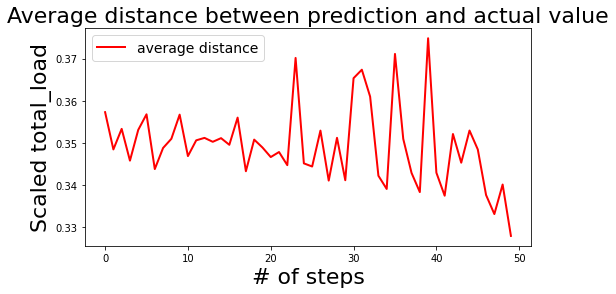

In [ ]:
# Plot the average distance between the predictions and actual data
fig = plt.figure(figsize=(8,4))
plt.plot(avg_error,label='average distance',c='red',linewidth=2.0)
plt.title('Average distance between prediction and actual value',fontsize=22)
plt.ylabel('Scaled total_load',fontsize=22)
plt.xlabel('# of steps',fontsize=22)
plt.legend(fontsize=14)
# Uncomment below to save figures
#plt.savefig('lstmavgdistance.png',bbox_inches='tight')

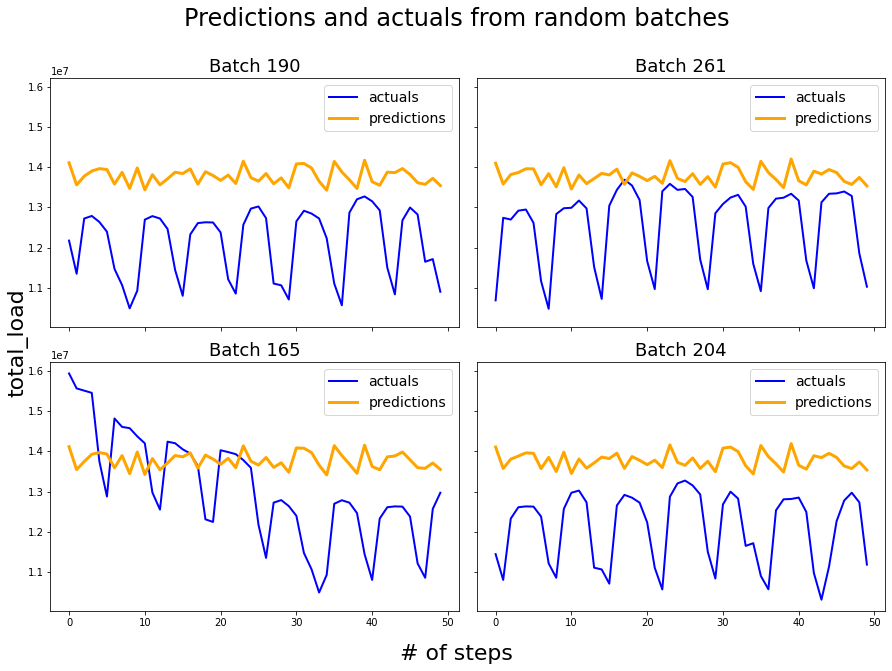

In [ ]:
# Plot predictions and actual data from random batches
fig, ax = plt.subplots(2,2,figsize=(12,8),constrained_layout=True,sharex=True,sharey=True)
fig.text(0.5, -0.05, '# of steps', ha='center',fontsize=22)
fig.text(-0.02, 0.5, 'total_load', va='center', rotation='vertical',fontsize=22)
fig.text(0.5,1.05,'Predictions and actuals from random batches',ha='center',fontsize=24)
for i in range(4):
  idx = np.random.randint(0,len(predictions))
  ax[i//2,i%2].plot(actuals[idx,:],c='blue',label='actuals',linewidth=2.0)
  ax[i//2,i%2].plot(predictions[idx,:],c='orange',label='predictions',linewidth=3.0)
  ax[i//2,i%2].set_title("Batch {}".format(idx),fontsize=18)
  ax[i//2,i%2].legend(fontsize=14)
  #ax[i].plot(actuals[idx,:],c='blue',label='actuals',linewidth=2.0)
  #ax[i].plot(predictions[idx,:],c='orange',label='predictions',linewidth=3.0)
  #ax[i].set_title("Batch {}".format(idx),fontsize=18)
  #ax[i].legend(fontsize=14)
plt.savefig('lstmpredictions1.png',bbox_inches='tight')

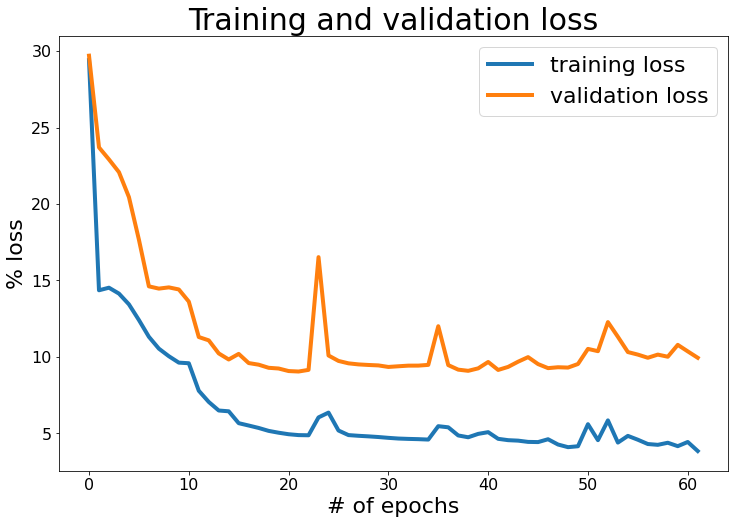

In [ ]:
# Plot the training and validation loss
fig = plt.figure(figsize=(12,8))
plt.plot(np.array(best_train_loss)*100,label='training loss',linewidth=4.0)
plt.plot(np.array(best_val_loss)*100, label='validation loss',linewidth=4.0)
plt.xlabel('# of epochs',size=22)
plt.ylabel('% loss',size=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Training and validation loss',size=30)
plt.legend(fontsize=22)
plt.savefig('lstmloss.png',bbox_inches='tight')